In [ ]:
!pip install rdkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 334 kB/s 


In [ ]:
!pip3 install datapane


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 26.6 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |████████████████████████████████| 100 kB 8.6 MB/s 
     |████████████████████████████████| 133 kB 51.8 MB/s 
     |████████████████████████████████| 563 kB 35.8 MB/s 
     |████████████████████████████████| 193 kB 43.9 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 495 kB 15.9 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
     |████████████████████████████████| 193 kB 50.3 MB/s 
     |████████████████████████████████| 140 kB 37.3 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 71 kB 157 kB/s 
     |████████████████████████████████| 107 kB 39.7 MB/s 
     |████████████████████████████████| 127 kB 18.5 MB/s 
     |████████████████████████████████| 62

In [ ]:
#Installing a package
!pip install git+https://github.com/samoturk/mol2vec;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-7lusd6_3
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-7lusd6_3
     |████████████████████████████████| 1.6 MB 4.5 MB/s 
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14038 sha256=8749fc2620a73335406214e5566dea907f007063cdb183e9e8dd5aaadb630dc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-bdbrol7l/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_regression, SelectFromModel
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from yellowbrick.regressor import ResidualsPlot
import datapane as dp



In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2022-10-07 08:51:52--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.001s  

2022-10-07 08:51:53 (53.1 MB/s) - ‘delaney.csv’ saved [58889/58889]



In [ ]:
!datapane login --token=0f5288937b220d142e4036df2b80bd82dc1469a9

Connected successfully to https://cloud.datapane.com as davide.luise@hotmail.it


In [ ]:
df = pd.read_csv('delaney.csv')

In [ ]:
df.shape

(1144, 4)

# Objective
---
In this notebook, we will make use of Machine Learning to predict the water solubility of molecule which is quite an important property in the field of drug discovery. This work has been inspired by the work of John S. Delaney (John S. Delaney. ESOL:? Estimating Aqueous Solubility Directly from Molecular Structure. J. Chem. Inf. Comput. Sci. 2004, 44, 3, 1000-1005).

The main idea is to fit a supervised model to a molecular structure dataset  in order to predict the water solubility just by making use of the smiles representation of molecules. In order to increase the accuracy of the model, the dataset will be augmented with features obtained as follows:
1. By deducing  molecular properties from SMILES by means of the rdkit package
2. By using the mol2vec method, which is an unsupervised machine learning approach used to obtain high dimensional embeddings of molecular substructures


SMILES stands for "simplified molecular-input line-entry system", and it's a string representation used for encoding molecular structures. They can by easily converted into two-dimensional and three-dimensional models of the molecules by most molecule editors. 

In [ ]:
df.isna().any()

Compound ID                             False
measured log(solubility:mol/L)          False
ESOL predicted log(solubility:mol/L)    False
SMILES                                  False
dtype: bool

In [ ]:
df.duplicated().any()

False

We will set the 'measured log solubility' as target feature. That's the one we want to predict.

In [ ]:
df = df.rename({'measured log(solubility:mol/L)':'Target'},axis=1)
df.drop('ESOL predicted log(solubility:mol/L)',axis=1,inplace=True)

# 1. Molecular Descriptors
---
We will make us of the rdkit package to get structural informations about the molecule and molecular properties such are molecular weight, logP, topological polar surface area and number of hydrogen bond donors and acceptors purely on the basis of the SMILES string of a molecule. In order to do that we first have to turn the SMILES structure into a MOL object.  

In [ ]:
# Let's transform the smiles to mol object

df['MOL'] = df.SMILES.apply(lambda x: Chem.MolFromSmiles(x))


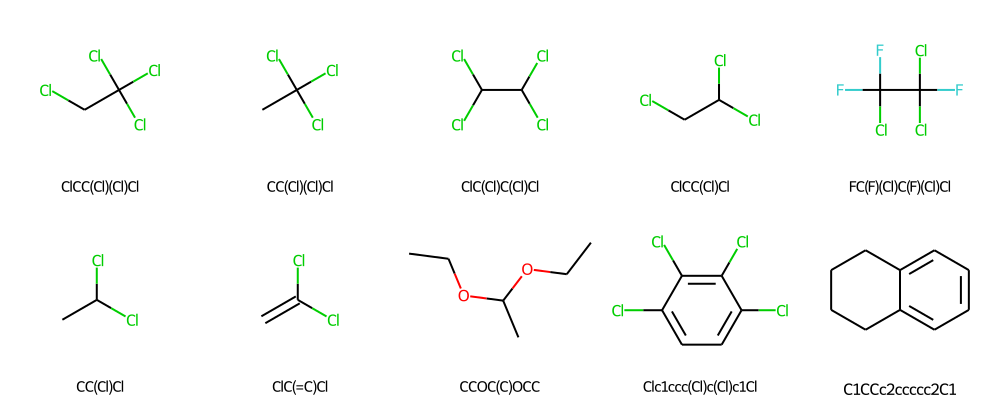

In [ ]:
# Let's visualize some molecules

molecules = df['MOL'][:10]

Draw.MolsToGridImage(molecules, molsPerRow=5, legends=list(df['SMILES'][:10].values))


Normally molecules are stored in the RDKit with the hydrogen atoms implicit. Hence we need to add explicit hydrogens atom to each molecule. After that, by exploiting the rdkit library we can add new features describing the structure of the molecules present in the dataset

In [ ]:
# Let's add H atoms to the Molecules
df['MOL'] = df['MOL'].apply(lambda x: Chem.AddHs(x))

# Let's get the number of total atoms in the molecules
df['num_atoms_tot'] = df['MOL'].apply(lambda x: x.GetNumAtoms())

# Let's get the number of atoms having molecular weight > 1
df['num_of_notH_atoms'] = df['MOL'].apply(lambda x: x.GetNumHeavyAtoms())



In [ ]:
# Count the number of most common atoms ('C','O', 'N', 'Cl')
common_atoms = ['C','O', 'N', 'Cl']

for atom in common_atoms:
  df['num_of_{}_atoms'.format(atom)] = df['MOL'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(atom))))

In [ ]:
# Count the number of aromatic rings
df['num_aromatic_rings'] = df['MOL'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x))

# Count the number of aliphatic rings
df['num_aliphatic_rings'] = df['MOL'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticRings(x))

Let's just check for example if the number of assigned aromatic rings is correct for the last 10 molecules of the dataset

In [ ]:
# let's make a legend containind the compound id and the associated number of aromatic rings
def tuple_list(string):
  return ' '.join(string)
result = map(tuple_list,list(zip(df.iloc[-10:]['Compound ID'].values,df.iloc[-10:]['num_aromatic_rings'].values.astype('str'))))
results = list(result)

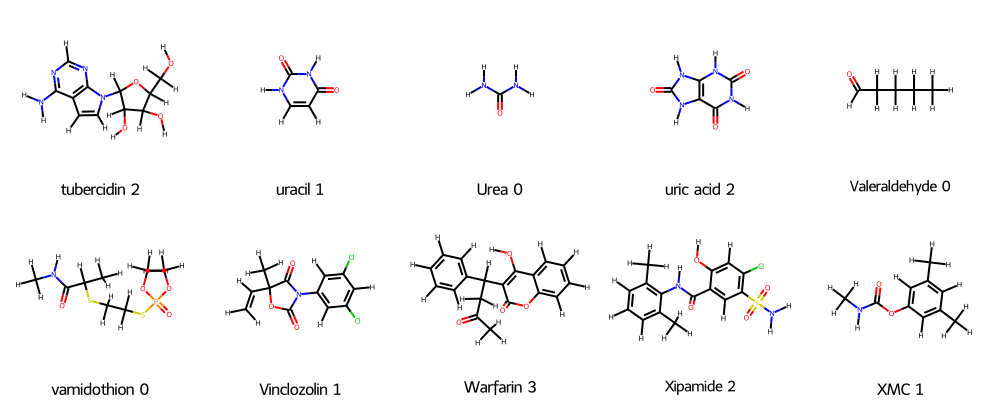

In [ ]:
molecules = df.iloc[-10:]['MOL']

Draw.MolsToGridImage(molecules, molsPerRow=5, legends=results)

#### Descriptors


Let's define some Descriptors which will be used as features to train the model

In [ ]:
'''rdkit.Chem.Descriptors.TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
rdkit.Chem.Descriptors.ExactMolWt() - exact molecural weight;
rdkit.Chem.Descriptors.NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
rdkit.Chem.Descriptors.NumHeteroatoms() - general number of non-carbon atoms'''

df['TPSA'] = df['MOL'].apply(lambda x: Descriptors.TPSA(x))
df['MOLW'] = df['MOL'].apply(lambda x: Descriptors.ExactMolWt(x))
df['valence_electrons'] = df['MOL'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_of_heteroatoms'] = df['MOL'].apply(lambda x: Descriptors.NumHeteroatoms(x))
df['nrotB'] = df['MOL'].apply(lambda x: Descriptors.NumRotatableBonds(x)) #Number of rotable bonds
df['HBD'] = df['MOL'].apply(lambda x: Descriptors.NumHDonors(x))  #Number of H bond donors
df['HBA'] = df['MOL'].apply(lambda x: Descriptors.NumHAcceptors(x))
df['LogP'] = df['MOL'].apply(lambda x: Descriptors.MolLogP(x))
    



In [ ]:
from google.colab import files

with open('example.csv', 'w') as f:
  f.write(df.drop('MOL',axis=1).to_csv())

files.download('example.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(df)

                         Compound ID  Target  \
0          1,1,1,2-Tetrachloroethane  -2.180   
1              1,1,1-Trichloroethane  -2.000   
2          1,1,2,2-Tetrachloroethane  -1.740   
3              1,1,2-Trichloroethane  -1.480   
4     1,1,2-Trichlorotrifluoroethane  -3.040   
...                              ...     ...   
1139                     vamidothion   1.144   
1140                     Vinclozolin  -4.925   
1141                        Warfarin  -3.893   
1142                        Xipamide  -3.790   
1143                             XMC  -2.581   

                                           SMILES  \
0                                  ClCC(Cl)(Cl)Cl   
1                                    CC(Cl)(Cl)Cl   
2                                  ClC(Cl)C(Cl)Cl   
3                                      ClCC(Cl)Cl   
4                             FC(F)(Cl)C(F)(Cl)Cl   
...                                           ...   
1139                 CNC(=O)C(C)SCCSP(=O)(OC)(OC)   

# EDA 
---
FEATURES vs TARGET

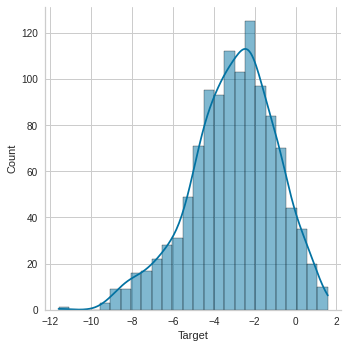

In [ ]:
sns.displot(df.Target,kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


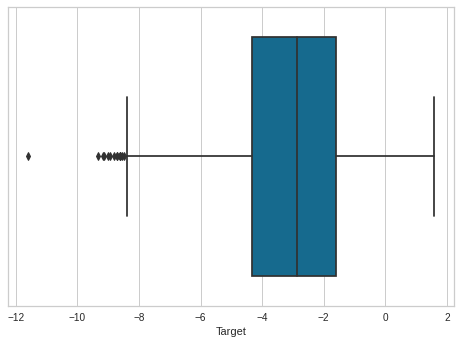

In [ ]:
sns.boxplot(df.Target)

We can notice from the above plots that there is an outlier compounds from the dataset. Let's take a look at it.

In [ ]:
df[df['Target'] < -10]

,Compound ID,Target,SMILES,MOL,num_atoms_tot,num_of_notH_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_aromatic_rings,num_aliphatic_rings,TPSA,MOLW,valence_electrons,num_of_heteroatoms,nrotB,HBD,HBA,LogP
116,"2,2',3,3',4,4',5,5',6,6'-PCB",-11.6,Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(C...,"<img data-content=""rdkit/molecule"" src=""data:i...",22,22,12,0,0,10,2,0,0.0,493.688527,118,10,1,0,0,9.8876


The compound of interest has very low solubility in water due to its large molecular weight. This is also confirmed by the high value of liphophilicity (logP)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Compound ID          1144 non-null   object 
 1   Target               1144 non-null   float64
 2   SMILES               1144 non-null   object 
 3   MOL                  1144 non-null   object 
 4   num_atoms_tot        1144 non-null   int64  
 5   num_of_notH_atoms    1144 non-null   int64  
 6   num_of_C_atoms       1144 non-null   int64  
 7   num_of_O_atoms       1144 non-null   int64  
 8   num_of_N_atoms       1144 non-null   int64  
 9   num_of_Cl_atoms      1144 non-null   int64  
 10  num_aromatic_rings   1144 non-null   int64  
 11  num_aliphatic_rings  1144 non-null   int64  
 12  TPSA                 1144 non-null   float64
 13  MOLW                 1144 non-null   float64
 14  valence_electrons    1144 non-null   int64  
 15  num_of_heteroatoms   1144 non-null   i

In [ ]:
df_num = df.select_dtypes(np.number)

In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Target               1144 non-null   float64
 1   num_atoms_tot        1144 non-null   int64  
 2   num_of_notH_atoms    1144 non-null   int64  
 3   num_of_C_atoms       1144 non-null   int64  
 4   num_of_O_atoms       1144 non-null   int64  
 5   num_of_N_atoms       1144 non-null   int64  
 6   num_of_Cl_atoms      1144 non-null   int64  
 7   num_aromatic_rings   1144 non-null   int64  
 8   num_aliphatic_rings  1144 non-null   int64  
 9   TPSA                 1144 non-null   float64
 10  MOLW                 1144 non-null   float64
 11  valence_electrons    1144 non-null   int64  
 12  num_of_heteroatoms   1144 non-null   int64  
 13  nrotB                1144 non-null   int64  
 14  HBD                  1144 non-null   int64  
 15  HBA                  1144 non-null   i

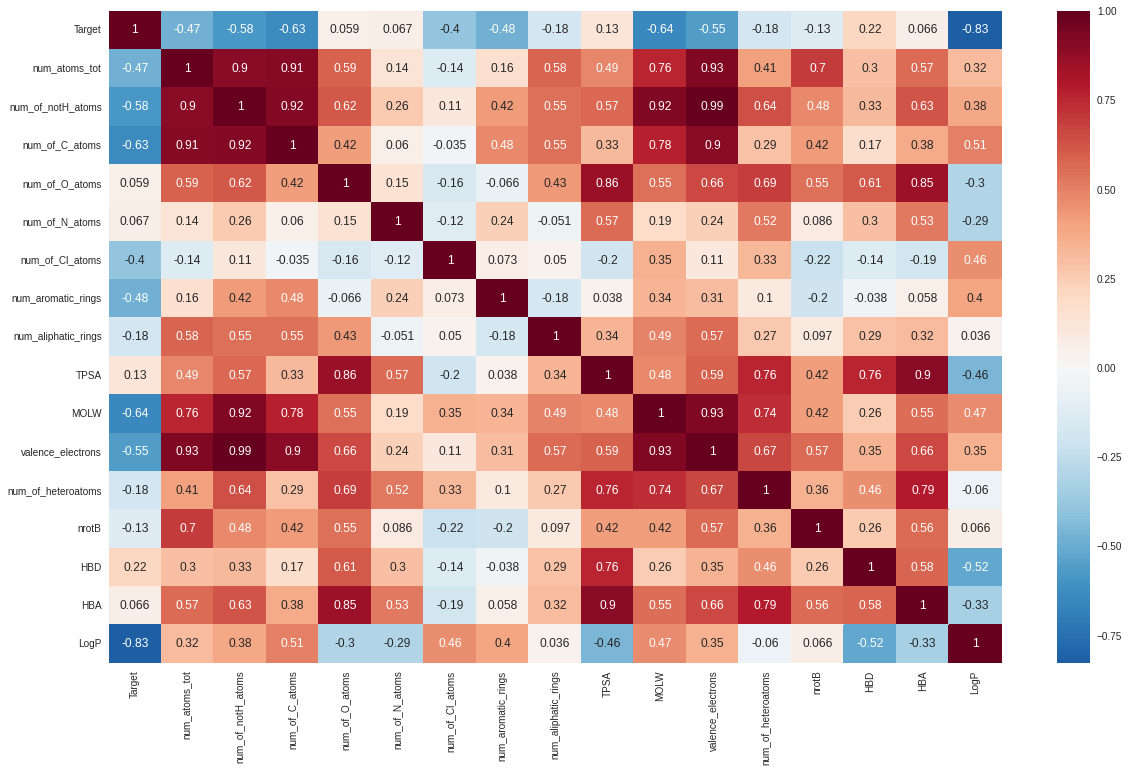

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(),center=0,cmap="RdBu_r",annot=True)

Most of the descriptors created are highly correlated between them. We will filter afterwards them based on the correlation with the target variable. In particular the features which are most correlated with the target are:
- num_of_C_atoms the higher the number of carbon atoms, the lower the solubility in water of the compound of interest. As it's known compounds composed by long carbon chains (oils, fatty acids) are not soluble in water
- MOLW, compounds having higher size tend to be less soluble in water 
- LogP, partition coefficient measures the liphophylicity of a compound, hence the higher the partition coefficient the lower the water solubility of the compound. 

In order to verify the applicability of the Linear Regression model, we check that the created features are linearly correlated with the target one by making use of scatterplots

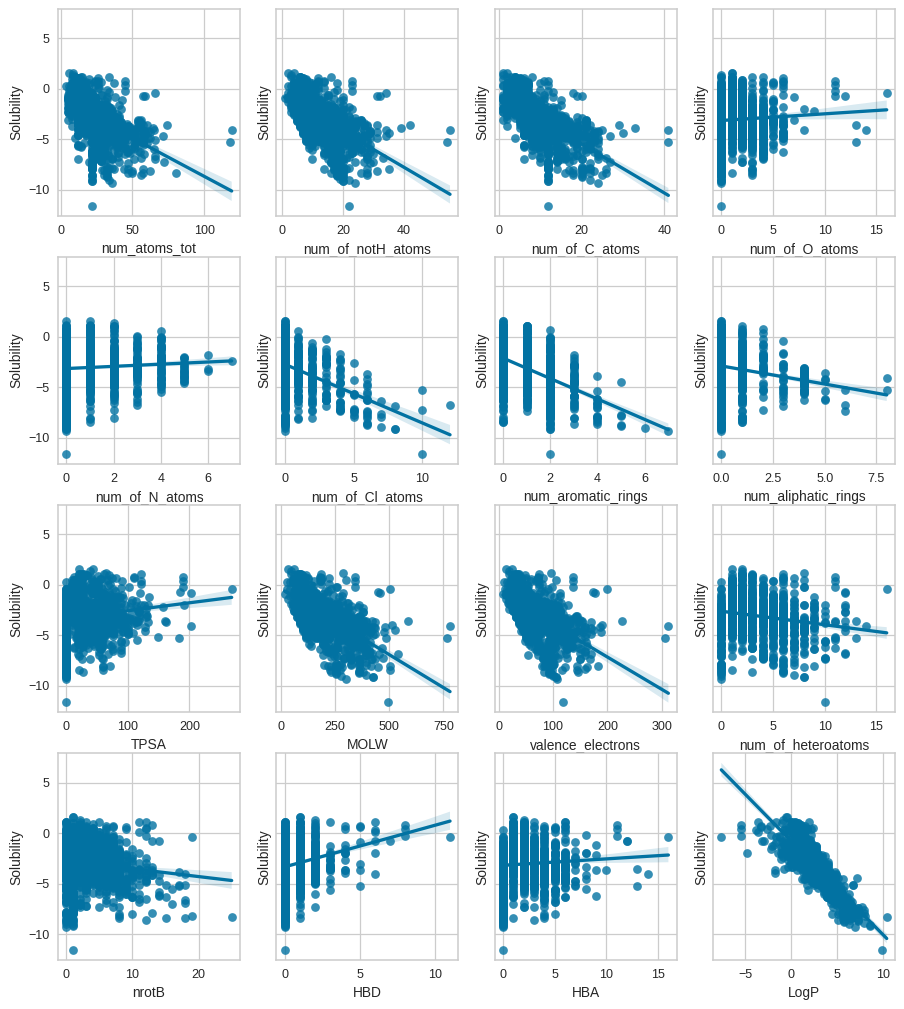

In [ ]:
#--- Now we check the selected variable have a linear correlation with the target

fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(12, 14), dpi=90)
axs = axs.flatten()
for i,feature in enumerate(df_num.drop('Target',axis=1).columns):
  sns.regplot(data=df_num,x=feature,y='Target',ax=axs[i])
  axs[i].set_ylabel('Solubility')


# Baseline model
---
Let's apply a linear regression model on the whole dataset to set a baseline score to improve.

In [ ]:
X = df.select_dtypes(np.number).drop('Target',axis=1)
y = df.Target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

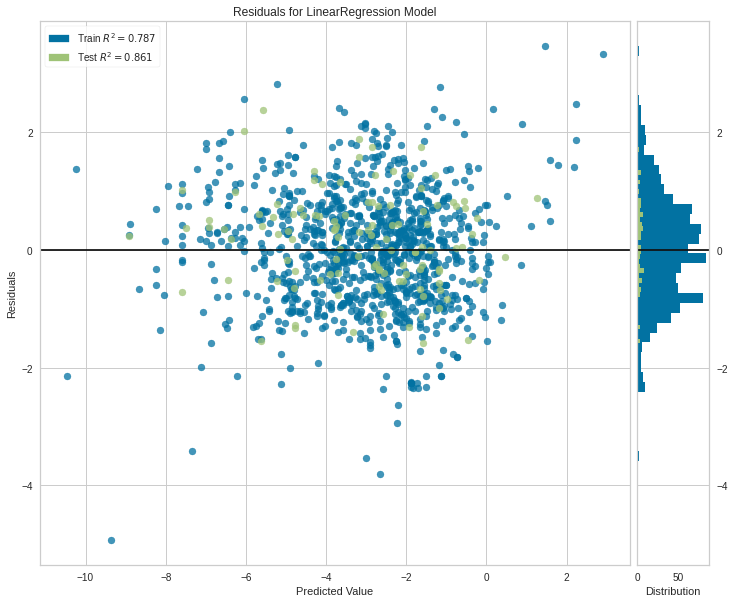

In [ ]:
lm = LinearRegression()

fig, ax = plt.subplots(1,1,figsize=(12,10))
visualizer = ResidualsPlot(lm,ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  




We can see a fairly random, uniform distribution of the residuals around 0 against the target, indicating that the linear regression model is appropriate for the data. 

## Feature Selection
---
Let's just keep the features which are the most correlated to the target variable to see if we get an improvement of the score.

In [ ]:
df.columns

Index(['Compound ID', 'Target', 'SMILES', 'MOL', 'num_atoms_tot',
       'num_of_notH_atoms', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_Cl_atoms', 'num_aromatic_rings',
       'num_aliphatic_rings', 'TPSA', 'MOLW', 'valence_electrons',
       'num_of_heteroatoms', 'nrotB', 'HBD', 'HBA', 'LogP'],
      dtype='object')

In [ ]:
X = df[['num_of_C_atoms','MOLW','LogP']]
y = df.Target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

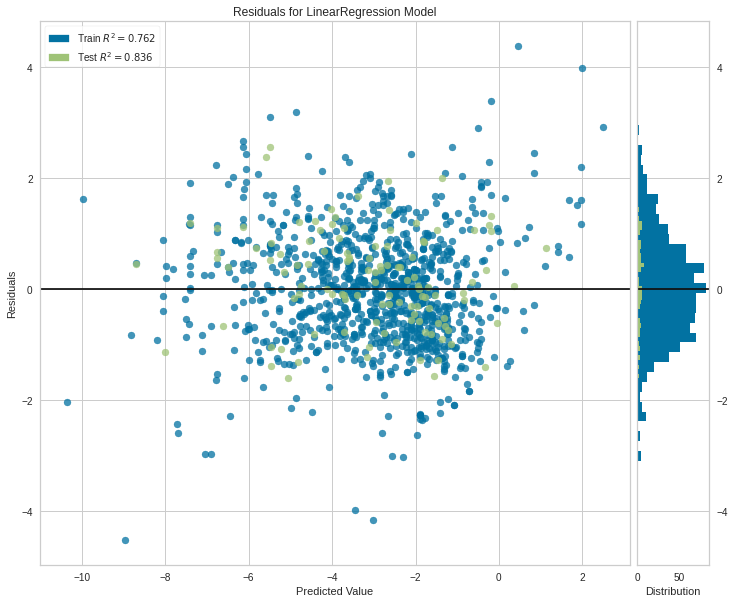

In [ ]:
lm = LinearRegression()

fig, ax = plt.subplots(1,1,figsize=(12,10))
visualizer = ResidualsPlot(lm,ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  




As we can see we did not get any improvement in the test r^2 score by selecting just a few highly correlated features. 

# Vector Representation of molecules: MOl2vec
---
Another way to fit a regression model on a molecular dataset made just of SMILES is to convert the smiles into vector representation. 
Similarly, to the Word2vec models where vectors of closely related
words are in close proximity in the vector space, Mol2vec learns vector representations of molecular substructures that are pointing in similar directions for chemically related substructures. Compounds can finally be encoded as vectors by summing up vectors of the individual substructures. 

In [ ]:
# again we will make use of the mol representation obtained from the smile of each molecule as starting point
mol_vec_df = df[['MOL','Target']]

In [ ]:
# Let's load a model which has been trained on 20M of different compounds
model = word2vec.Word2Vec.load(r'/content/drive/MyDrive/model_300dim.pkl')

In [ ]:
# Let's create molecular embeddings by generating molecular sentences with mol2alt_sequence() and then vectorize them with sentence2vec()
mol_vec_df['sentence'] = mol_vec_df.apply(lambda x: MolSentence(mol2alt_sentence(x['MOL'],1)),axis=1)
mol_vec_df['mol_vec'] = [DfVec(x) for x in sentences2vec(mol_vec_df['sentence'], model, unseen='UNK')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X_vec = np.array([x.vec for x in mol_vec_df['mol_vec']])
y_vec = mol_vec_df.Target

In [ ]:
X_vec.shape

(1144, 300)

The molecular embedding has generated 300 new features representing the vector representation of each molecule

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, test_size=.1, random_state=1)

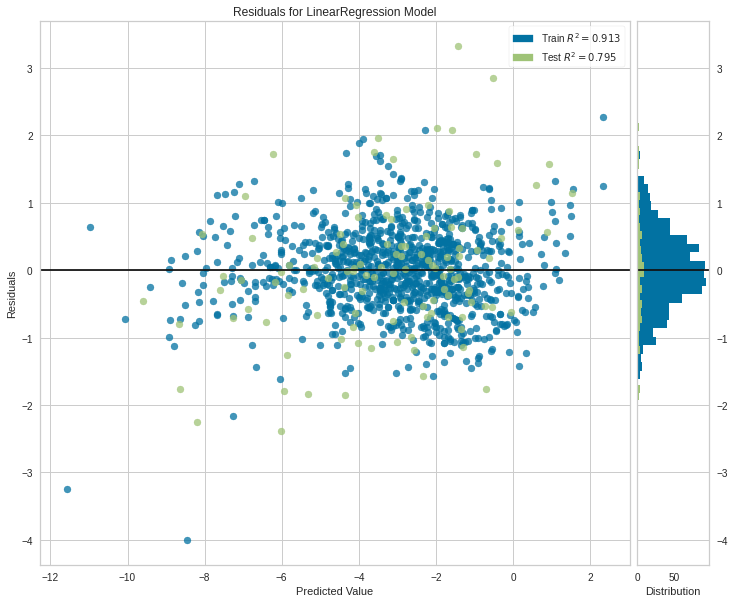

In [ ]:
lm2 = LinearRegression()

fig, ax = plt.subplots(1,1,figsize=(12,10))
visualizer = ResidualsPlot(lm2,ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

In this case our model is clearly overfitting the dataset providing r^2 score on the test set of about 0.8. This is probably due to the fact the we have a too small dataset with 300 features. 
Let's try to reduce it by applying dimensionality reduction techniques

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_vec_pca = pca.fit_transform(X_vec)

We apply dimensionality reduction by PCA due the the large number of features. 

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9958446

The total explained variance obtained by using 50 features instead of 300 is still very high, meaning that we are keeping almost all the information encoded in the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vec_pca, y_vec, test_size=.1, random_state=1)

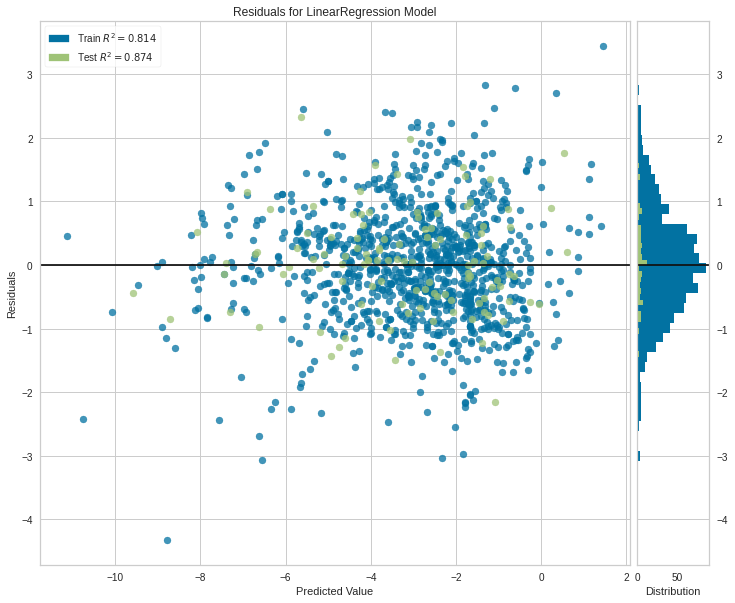

In [ ]:
lm3 = LinearRegression()
fig, ax = plt.subplots(1,1,figsize=(12,10))
visualizer = ResidualsPlot(lm3,ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

By using PCA we solved the overfitting problem and we also improved the r^2 score on the test set of about 8% (which is huge)

The last step to do now is to concatenate the descriptors features created in the first part by using rdkit package with the PCA components we just obtained 

In [ ]:
df2 = pd.DataFrame(X_vec_pca)

new_df = pd.concat((df2,df.select_dtypes(np.number).drop('Target',axis=1)),axis=1)

In [ ]:
new_df.shape

(1144, 66)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df,y,test_size=0.1,random_state=1)

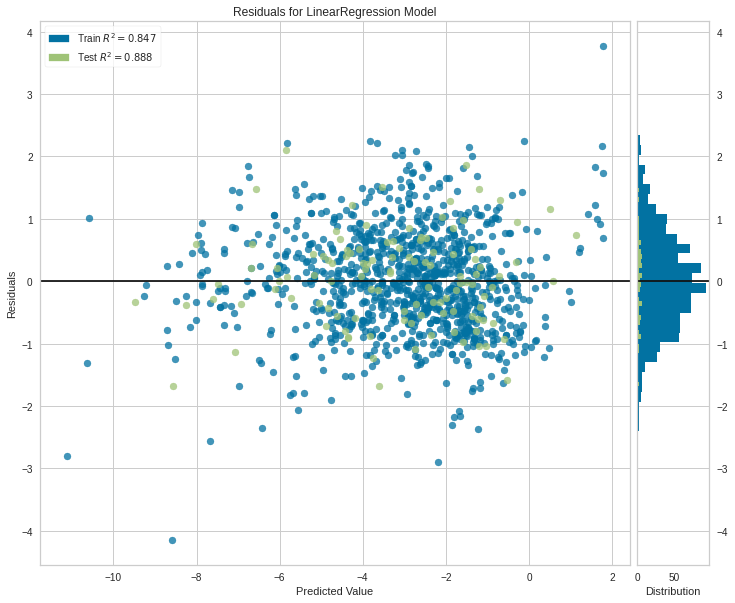

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
lm4 = LinearRegression()
fig, ax = plt.subplots(1,1,figsize=(12,10))
visualizer = ResidualsPlot(lm4,ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

By using the two joined methodologies we finally obtained a score of 89% with an improvement of 3% compared to the baseline model. 